# AutoARIMA Comparison (Prophet and pmdarima)

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/experiments/AutoArima_vs_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Motivation

The `AutoARIMA` model is widely used to forecast time series in production and as a benchmark. However, the python implementation (`pmdarima`) is so slow that prevent data scientist practioners from quickly iterating and deploying `AutoARIMA` in production for a large number of time series. In this notebook we present Nixtla's `AutoARIMA` based on the R implementation (developed by Rob Hyndman) and optimized using `numba`.

## Example

### Libraries

In [ ]:
%%capture
# !pip install statsforecast prophet statsmodels sklearn matplotlib pmdarima

In [ ]:
import logging
import os
import random
import time
import warnings
warnings.filterwarnings("ignore")
from itertools import product
from multiprocessing import cpu_count, Pool # for prophet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima as auto_arima_p
from prophet import Prophet
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, _TS
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import ParameterGrid
from utilsforecast.plotting import plot_series

#### Useful functions

In [ ]:
def plot_autocorrelation_grid(df_train):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    unique_ids = random.sample(list(unique_ids), k=8)

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        plot_acf(train_uid['y'].values, ax=axes[idx, idy], 
                 title=f'ACF M4 Hourly {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Autocorrelation')
    fig.subplots_adjust(hspace=0.5)
    plt.show()

### Data

For testing purposes, we will use the Hourly dataset from the M4 competition.

In [ ]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 16
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

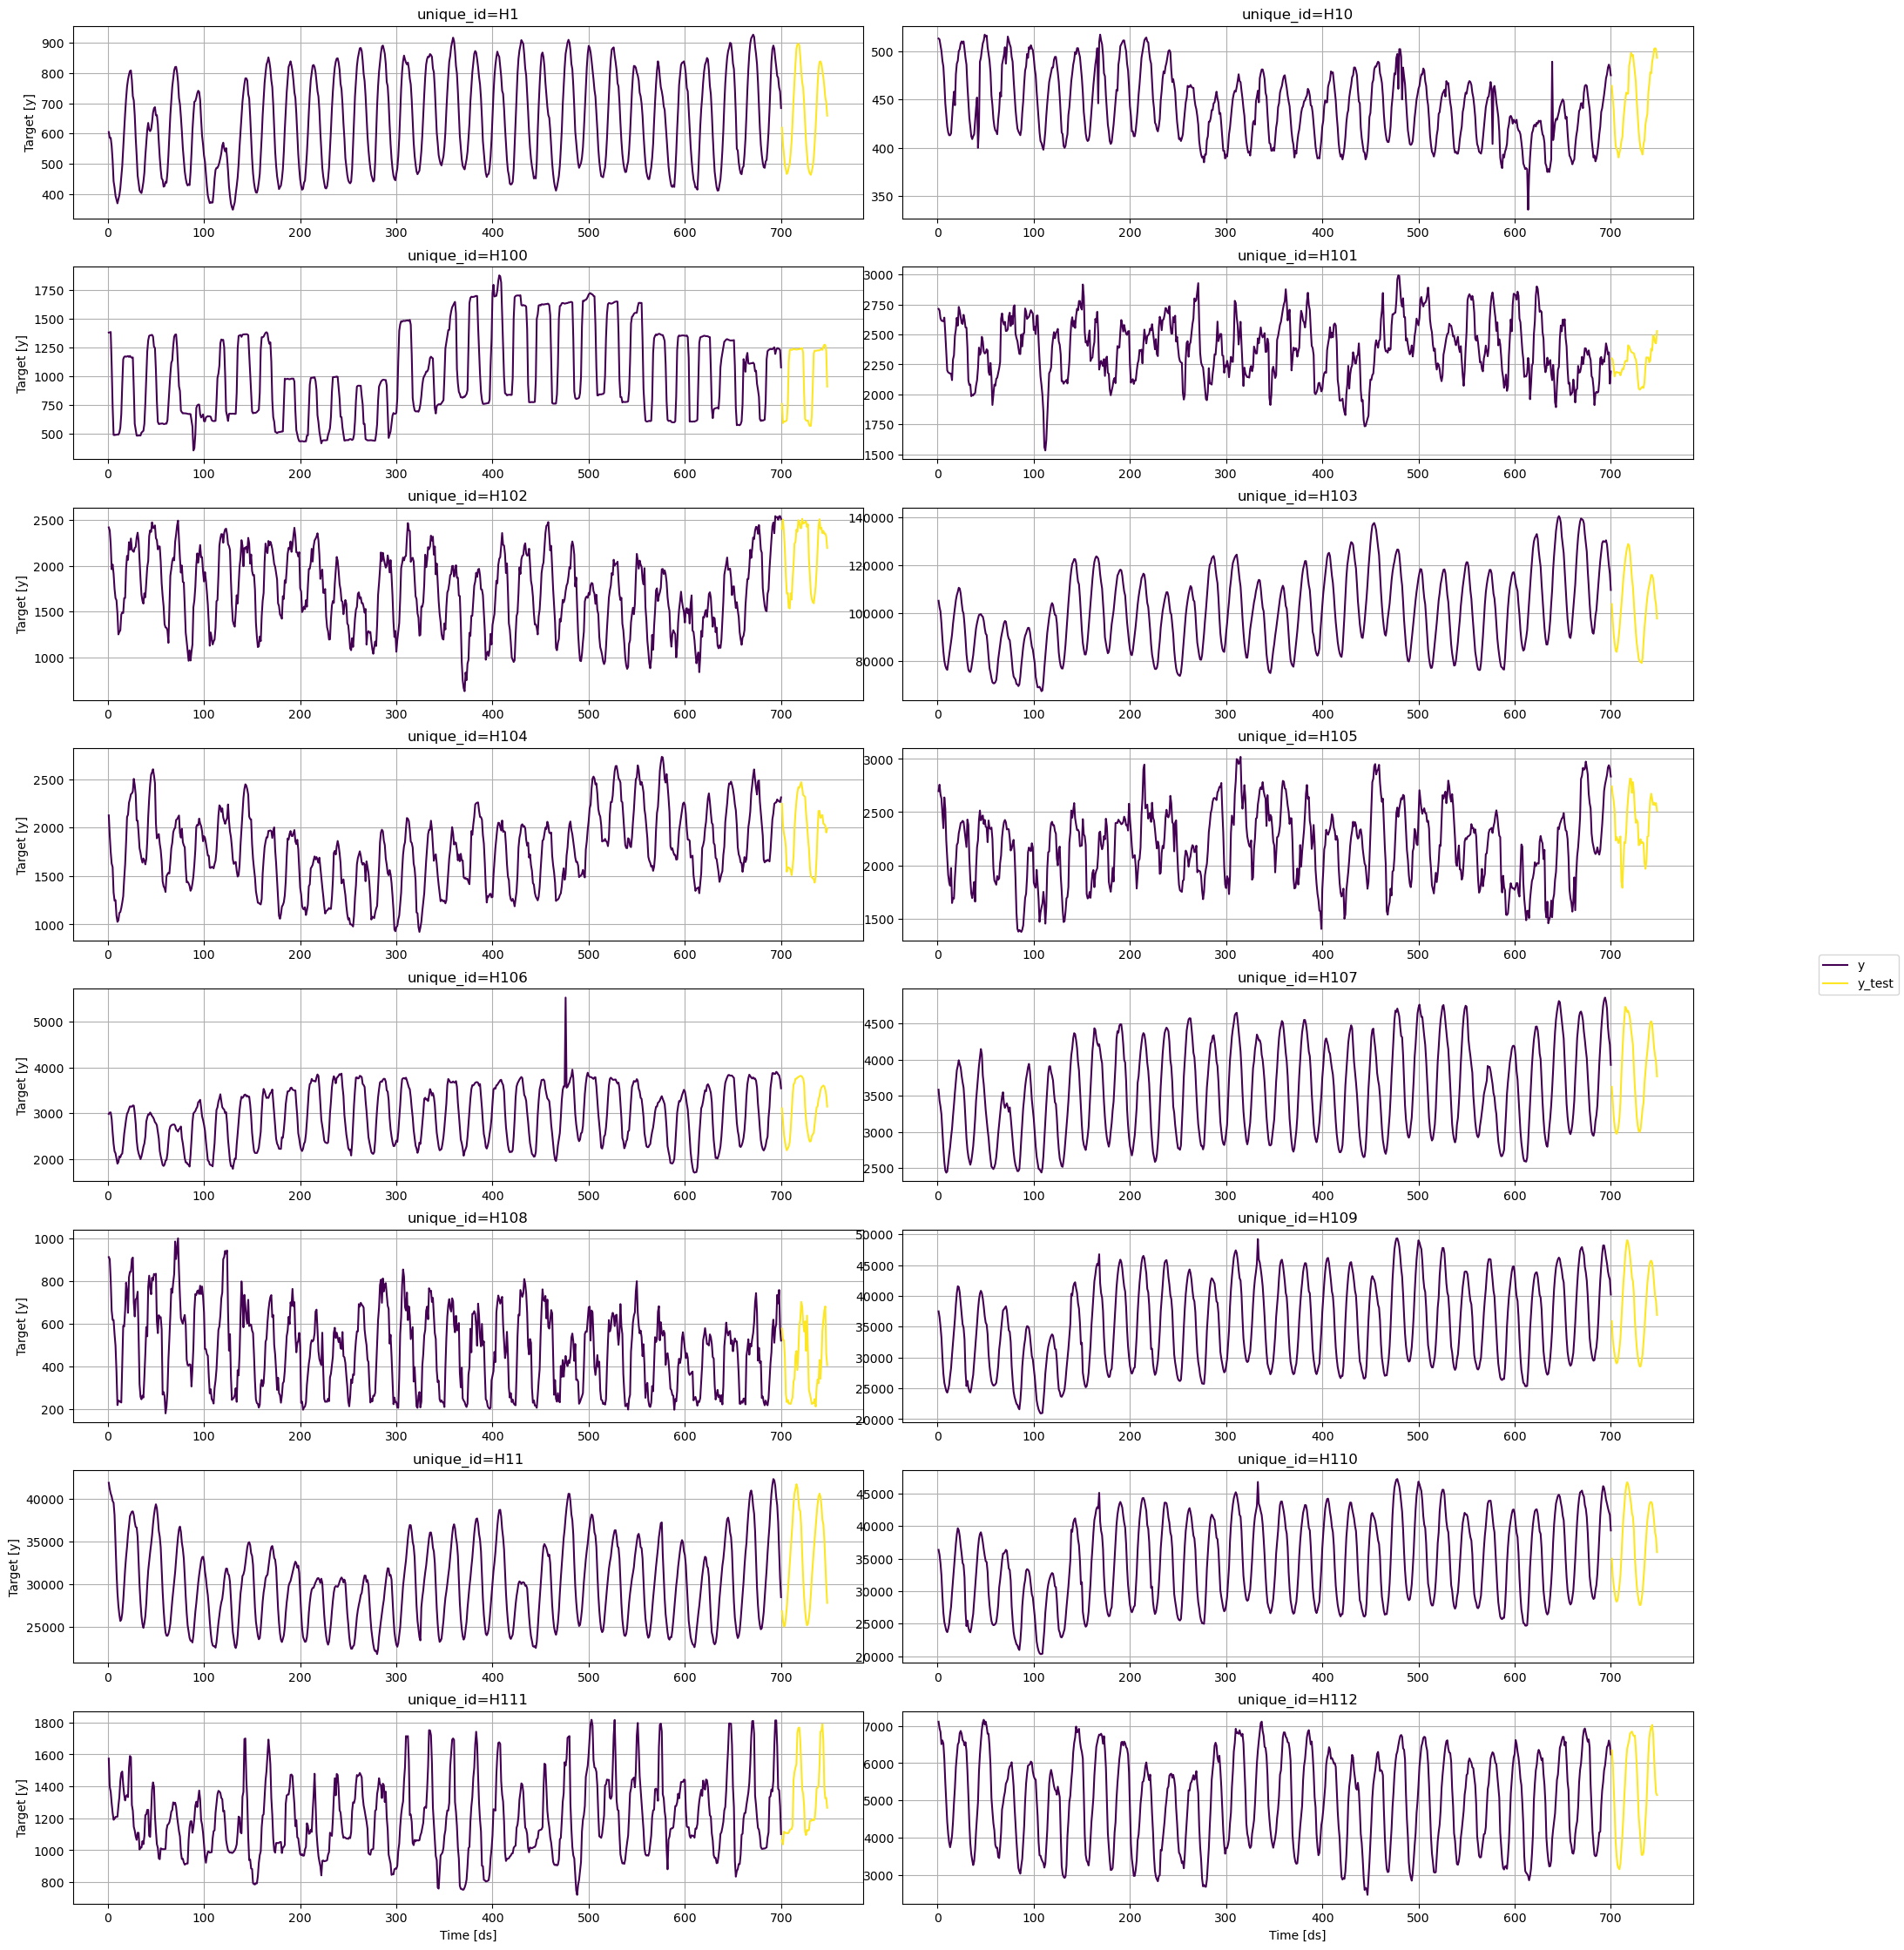

In [ ]:
plot_series(train, test, max_ids=n_series)

Would an autorregresive model be the right choice for our data? There is no doubt that we observe seasonal periods. The autocorrelation function (`acf`) can help us to answer the question. Intuitively, we have to observe a decreasing correlation to opt for an AR model. 

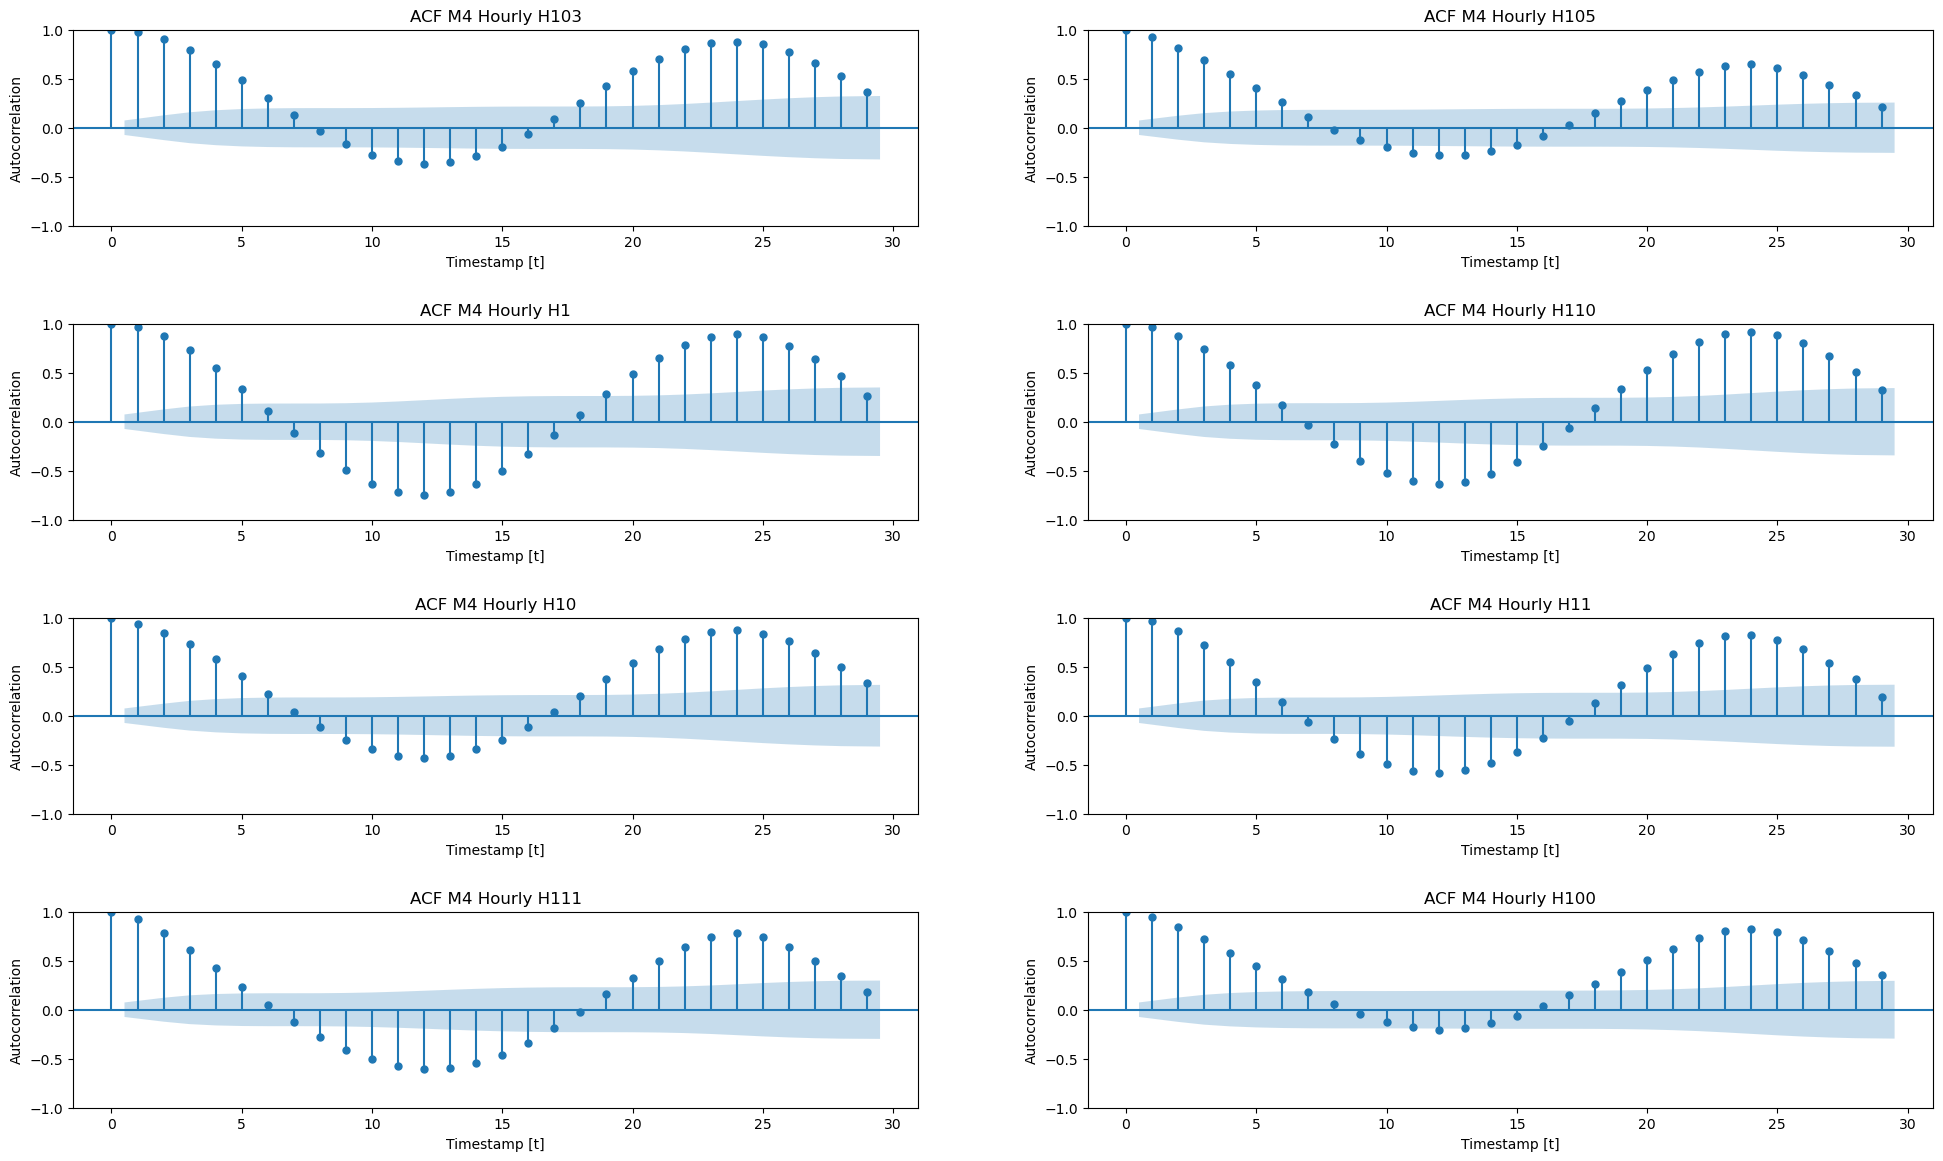

In [ ]:
plot_autocorrelation_grid(train)

Thus, we observe a high autocorrelation for previous lags and also for the seasonal lags. Therefore, we will let `auto_arima` to handle our data.

### Training and forecasting

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Hourly data, it would be benefitial to use 24 as seasonality.

In [ ]:
?AutoARIMA

Init signature:
AutoARIMA(
    d: Optional[int] = None,
    D: Optional[int] = None,
    max_p: int = 5,
    max_q: int = 5,
    max_P: int = 2,
    max_Q: int = 2,
    max_order: int = 5,
    max_d: int = 2,
    max_D: int = 1,
    start_p: int = 2,
    start_q: int = 2,
    start_P: int = 1,
    start_Q: int = 1,
    stationary: bool = False,
    seasonal: bool = True,
    ic: str = 'aicc',
    stepwise: bool = True,
    nmodels: int = 94,
    trace: bool = False,
    approximation: Optional[bool] = False,
    method: Optional[str] = None,
    truncate: Optional[bool] = None,
    test: str = 'kpss',
    test_kwargs: Optional[str] = None,
    seasonal_test: str = 'seas',
    seasonal_test_kwargs: Optional[Dict] = None,
    allowdrift: bool = False,
    allowmean: bool = False,
    blambda: Optional[float] = None,
    biasadj: bool = False,
    season_length: int = 1,
    alias: str = 'AutoARIMA',
    prediction_intervals: Optional[statsforecast.utils.ConformalIntervals] = None,
)
Docs

As we see, we can pass `season_length` to `AutoARIMA`, so the definition of our models would be,

In [ ]:
models = [AutoARIMA(season_length=24, approximation=True)]

In [ ]:
fcst = StatsForecast(df=train, 
                     models=models, 
                     freq='H', 
                     n_jobs=-1)

In [ ]:
init = time.time()
forecasts = fcst.forecast(48)
end = time.time()

time_nixtla = end - init
time_nixtla

40.38660216331482

In [ ]:
forecasts.head()

,ds,AutoARIMA
unique_id,,
H1,701,616.084167
H1,702,544.432129
H1,703,510.414490
H1,704,481.046539
H1,705,460.893066


In [ ]:
forecasts = forecasts.reset_index()

In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

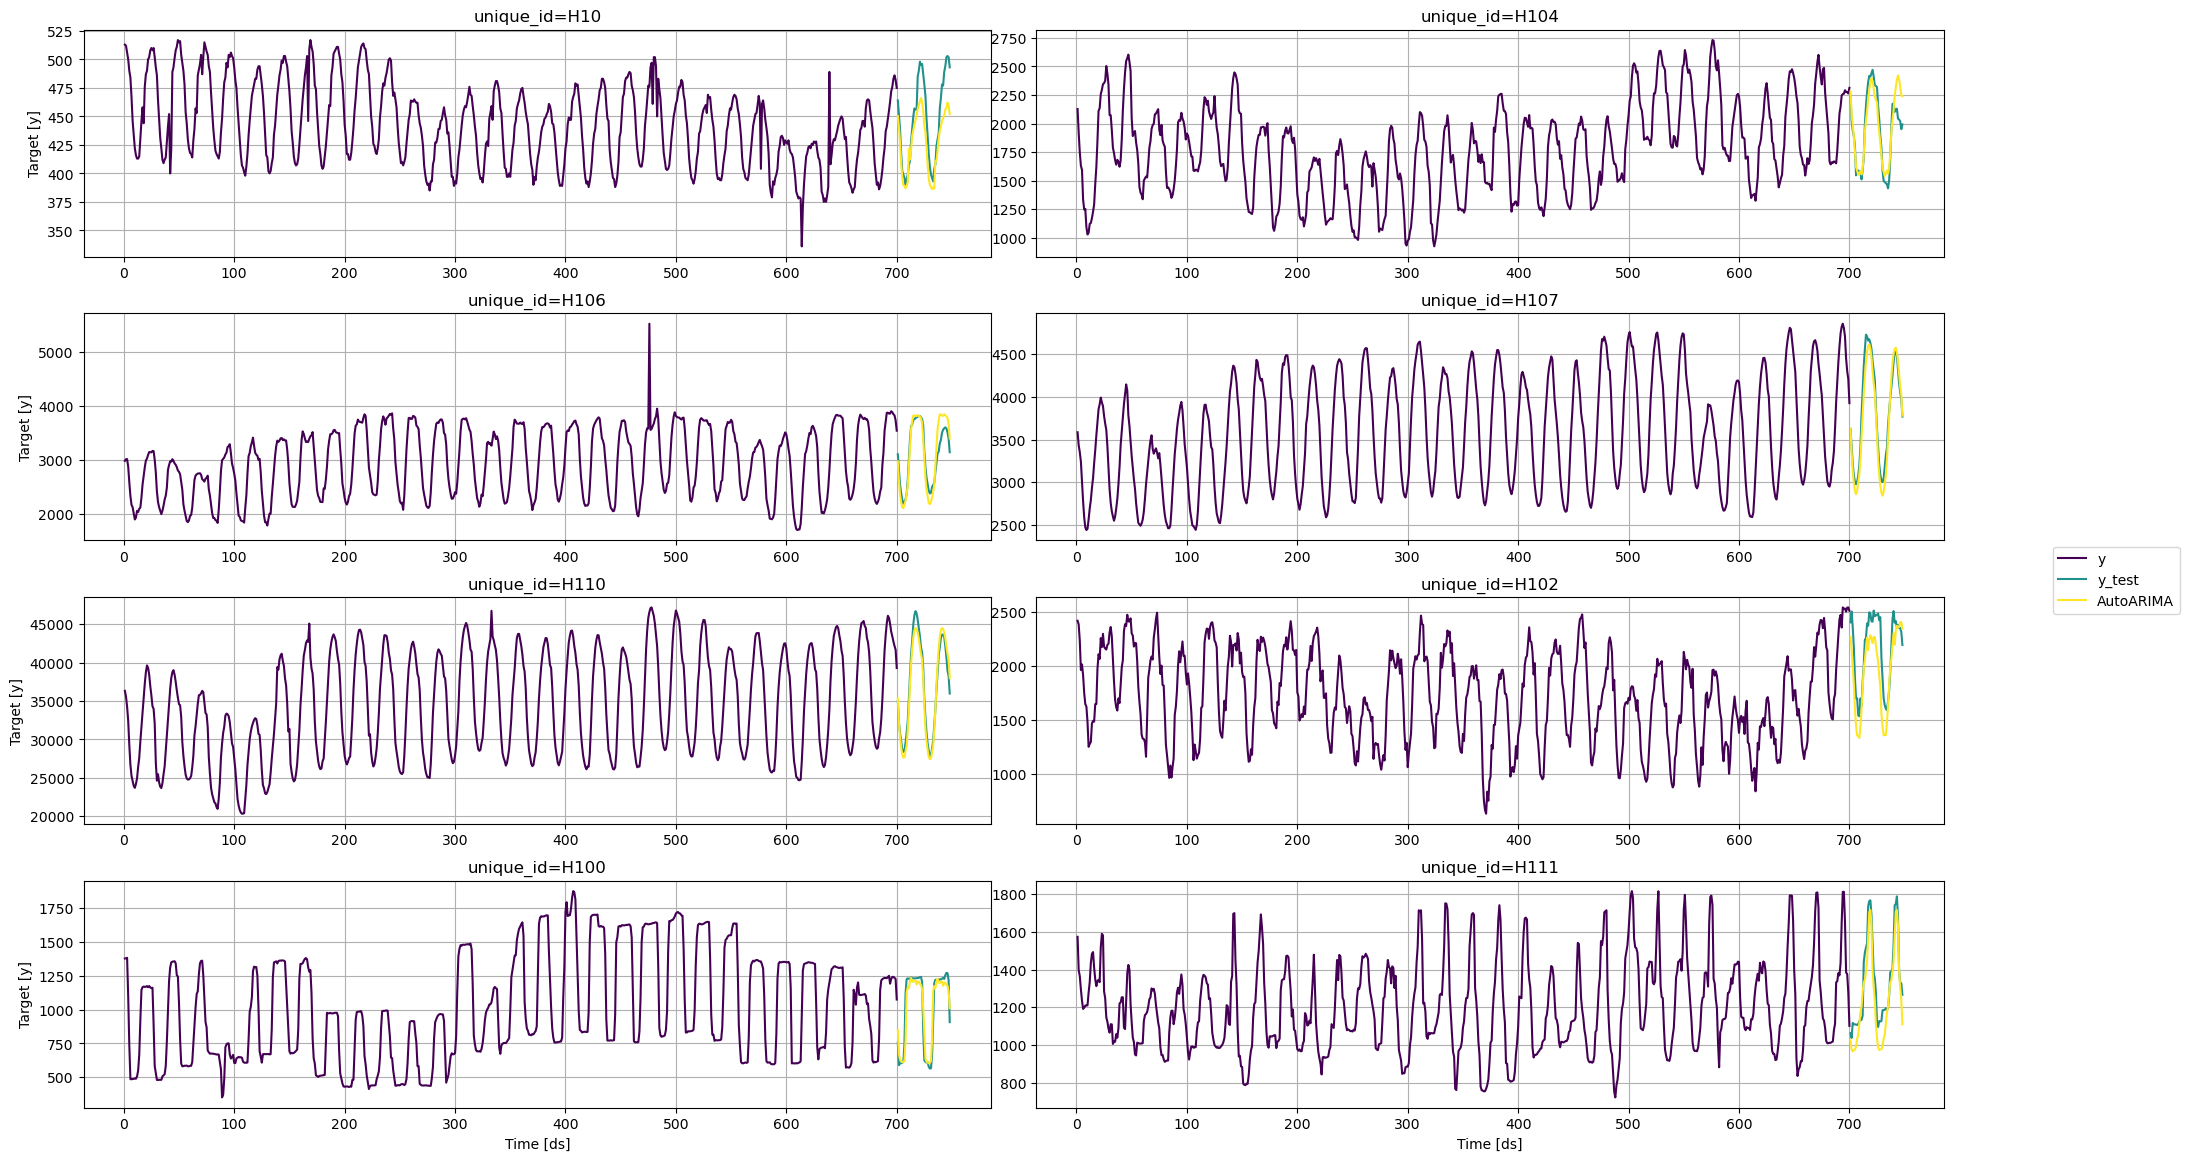

In [ ]:
plot_series(train, test)

## Alternatives

### pmdarima

You can use the `StatsForecast` class to parallelize your own models. In this section we will use it to run the `auto_arima` model from `pmdarima`.

In [ ]:
class PMDAutoARIMA(_TS):
    
    def __init__(self, season_length: int):
        self.season_length = season_length
        
    def forecast(self, y, h, X=None, X_future=None, fitted=False):
        mod = auto_arima_p(
            y, m=self.season_length,
            with_intercept=False #ensure comparability with Nixtla's implementation
        ) 
        return {'mean': mod.predict(h)}
    
    def __repr__(self):
        return 'pmdarima'

In [ ]:
n_series_pmdarima = 2

In [ ]:
fcst = StatsForecast(
    df = train.query('unique_id in ["H1", "H10"]'), 
    models=[PMDAutoARIMA(season_length=24)],
    freq='H',
    n_jobs=-1
)

In [ ]:
init = time.time()
forecast_pmdarima = fcst.forecast(48)
end = time.time()

time_pmdarima = end - init
time_pmdarima

886.2768685817719

In [ ]:
forecast_pmdarima.head()

,ds,pmdarima
unique_id,,
H1,701,628.310547
H1,702,571.659851
H1,703,543.504700
H1,704,517.539062
H1,705,502.829559


In [ ]:
forecast_pmdarima = forecast_pmdarima.reset_index()

In [ ]:
test = test.merge(forecast_pmdarima, how='left', on=['unique_id', 'ds'])

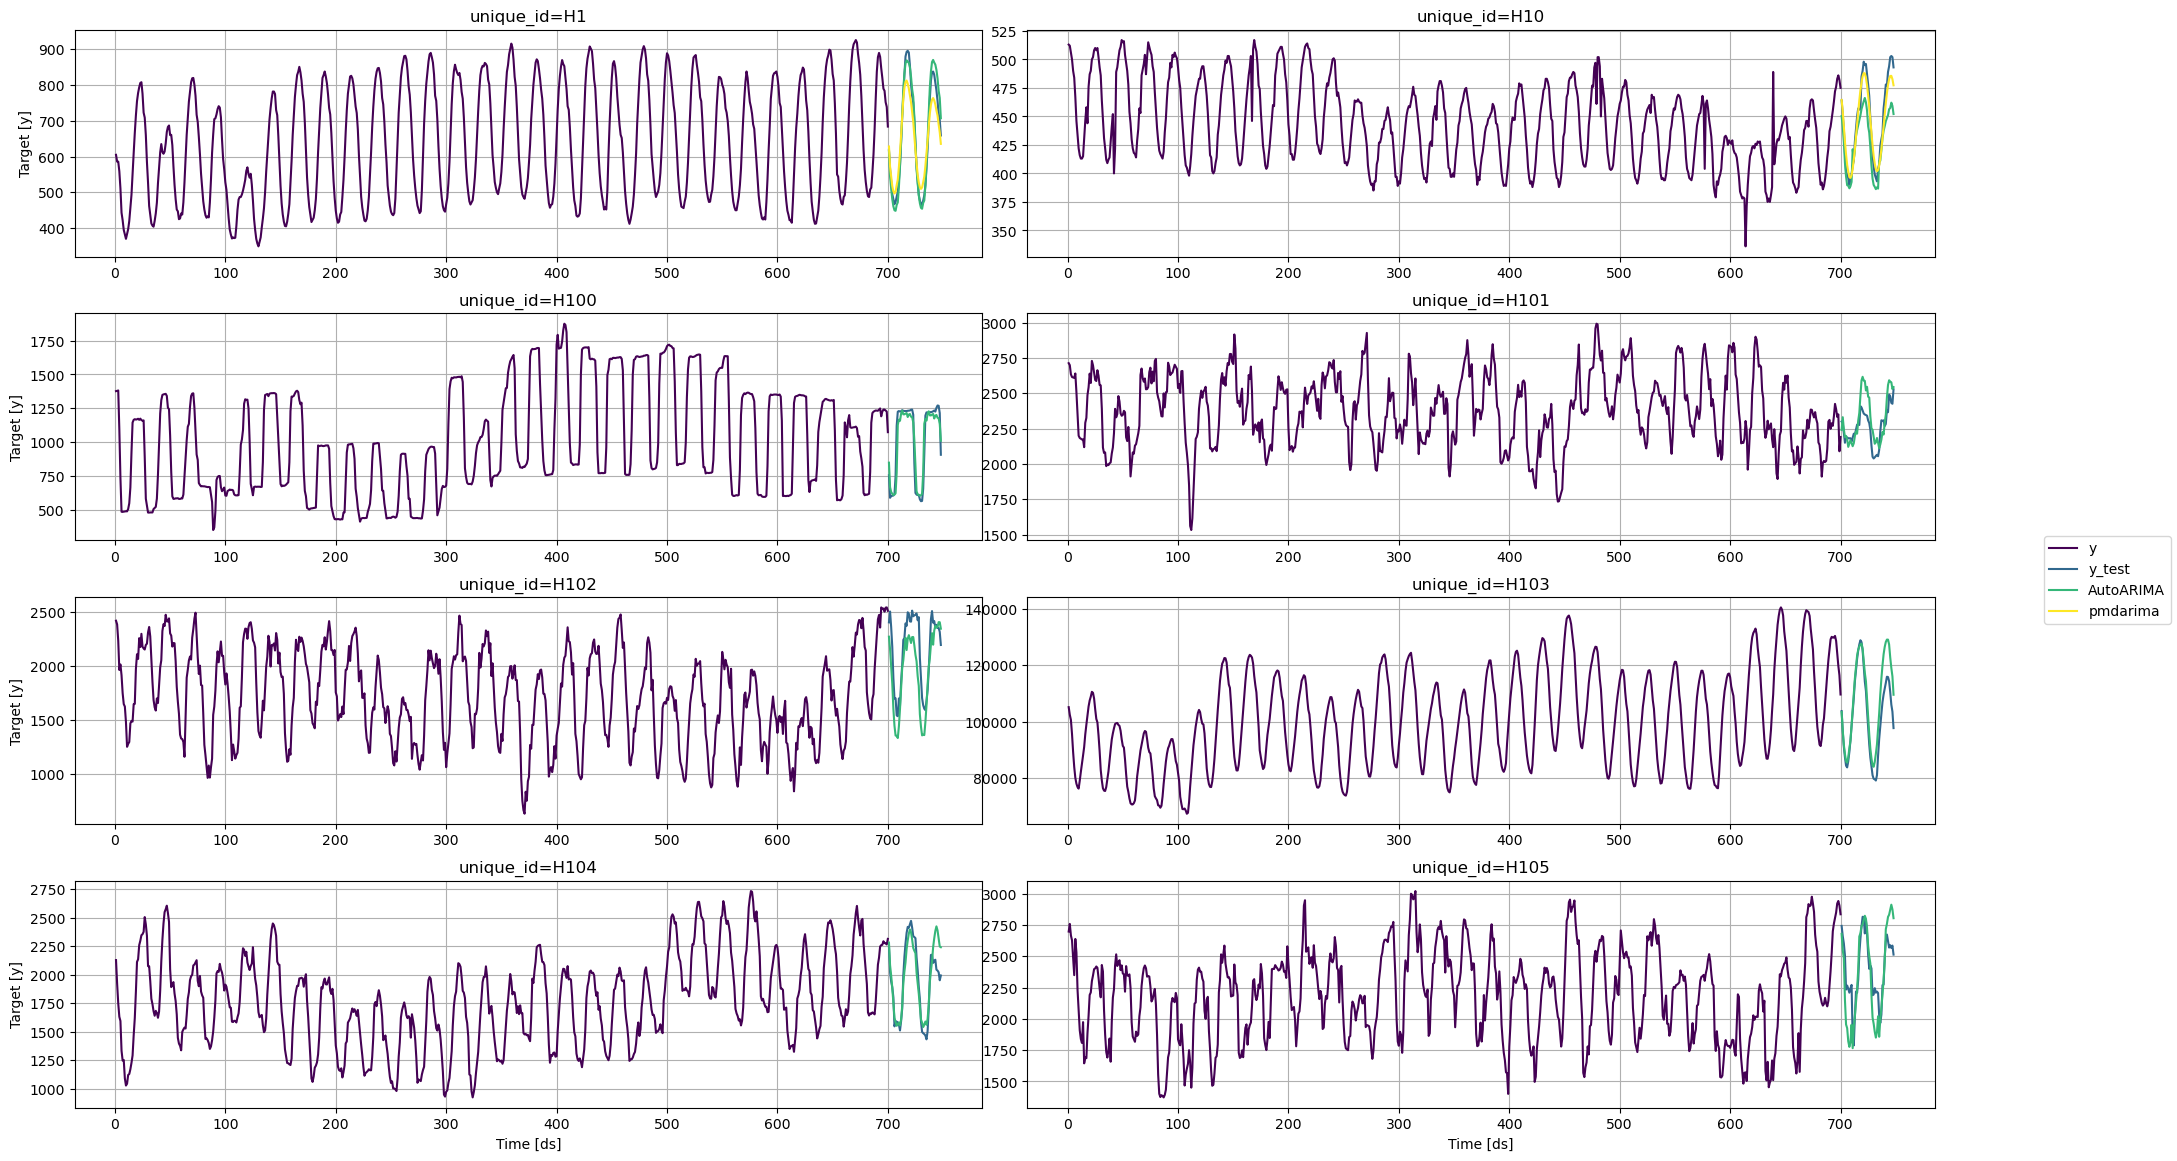

In [ ]:
plot_series(train, test, plot_random=False)

### Prophet 

`Prophet` is designed to receive a pandas dataframe, so we cannot use `StatForecast`. Therefore, we need to parallize from scratch.

In [ ]:
params_grid = {'seasonality_mode': ['multiplicative','additive'],
               'growth': ['linear', 'flat'], 
               'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5], 
               'n_changepoints': [5, 10, 15, 20]} 
grid = ParameterGrid(params_grid)

In [ ]:
def fit_and_predict(index, ts):
    df = ts.drop(columns='unique_id', axis=1)
    max_ds = df['ds'].max()
    df['ds'] = pd.date_range(start='1970-01-01', periods=df.shape[0], freq='H')
    df_val = df.tail(48) 
    df_train = df.drop(df_val.index) 
    y_val = df_val['y'].values
    
    if len(df_train) >= 48:
        val_results = {'losses': [], 'params': []}

        for params in grid:
            model = Prophet(seasonality_mode=params['seasonality_mode'],
                            growth=params['growth'],
                            weekly_seasonality=True,
                            daily_seasonality=True,
                            yearly_seasonality=True,
                            n_changepoints=params['n_changepoints'],
                            changepoint_prior_scale=params['changepoint_prior_scale'])
            model = model.fit(df_train)
            
            forecast = model.make_future_dataframe(periods=48, 
                                                   include_history=False, 
                                                   freq='H')
            forecast = model.predict(forecast)
            forecast['unique_id'] = index
            forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
            
            loss = np.mean(abs(y_val - forecast['yhat'].values))
            
            val_results['losses'].append(loss)
            val_results['params'].append(params)

        idx_params = np.argmin(val_results['losses']) 
        params = val_results['params'][idx_params]
    else:
        params = {'seasonality_mode': 'multiplicative',
                  'growth': 'flat',
                  'n_changepoints': 150,
                  'changepoint_prior_scale': 0.5}
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    growth=params['growth'],
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True,
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    model = model.fit(df)
    
    forecast = model.make_future_dataframe(periods=48, 
                                           include_history=False, 
                                           freq='H')
    forecast = model.predict(forecast)
    forecast.insert(0, 'unique_id', index)
    forecast['ds'] = np.arange(max_ds + 1, max_ds + 48 + 1)
    forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
    
    return forecast

In [ ]:
#| echo: false
logging.getLogger('prophet').setLevel(logging.ERROR)
stan_logger = logging.getLogger('cmdstanpy')
stan_logger.addHandler(logging.NullHandler())
stan_logger.propagate = False
stan_logger.setLevel(logging.ERROR)

In [ ]:
init = time.time()
with Pool(cpu_count()) as pool:
    forecast_prophet = pool.starmap(fit_and_predict, train.groupby('unique_id'))
end = time.time()
forecast_prophet = pd.concat(forecast_prophet).rename(columns={'yhat': 'prophet'})
time_prophet = end - init
time_prophet

120.7272641658783

In [ ]:
forecast_prophet

,unique_id,ds,prophet
0,H1,701,635.914254
1,H1,702,565.976464
2,H1,703,505.095507
3,H1,704,462.559539
4,H1,705,438.766801
...,...,...,...
43,H112,744,6184.686240
44,H112,745,6188.851888
45,H112,746,6129.306256
46,H112,747,6058.040672


In [ ]:
test = test.merge(forecast_prophet, how='left', on=['unique_id', 'ds'])

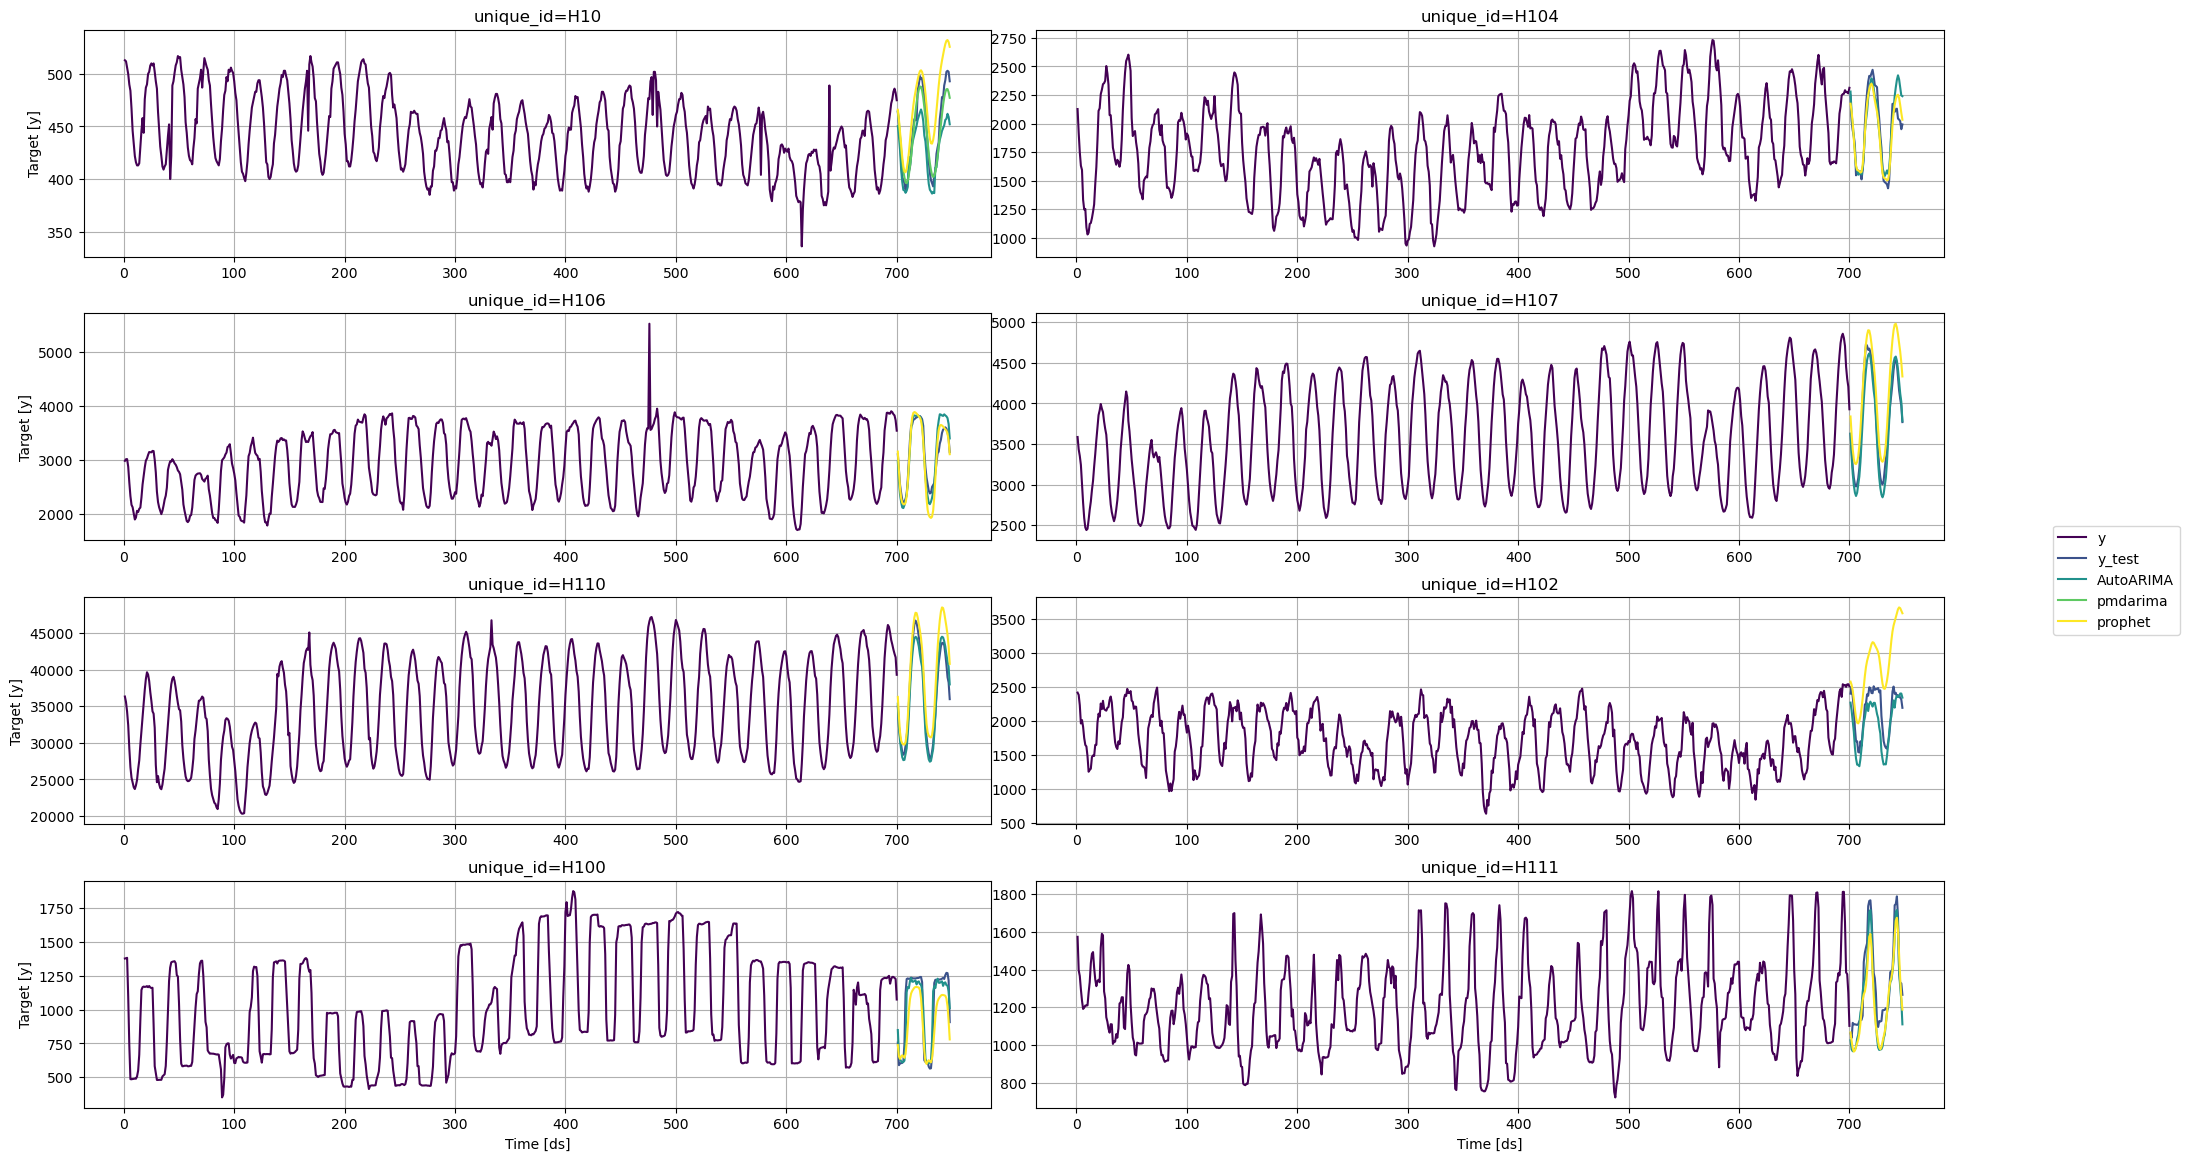

In [ ]:
plot_series(train, test)

### Evaluation

### Time

Since `AutoARIMA` works with numba is useful to calculate the time for just one time series.

In [ ]:
fcst = StatsForecast(df=train.query('unique_id == "H1"'), 
                     models=models, freq='H', 
                     n_jobs=1)

In [ ]:
init = time.time()
forecasts = fcst.forecast(48)
end = time.time()

time_nixtla_1 = end - init
time_nixtla_1 

18.752424716949463

In [ ]:
times = pd.DataFrame({'n_series': np.arange(1, 414 + 1)})
times['pmdarima'] = time_pmdarima * times['n_series'] / n_series_pmdarima
times['prophet'] = time_prophet * times['n_series'] / n_series
times['AutoARIMA_nixtla'] = time_nixtla_1 + times['n_series'] * (time_nixtla - time_nixtla_1) / n_series
times = times.set_index('n_series')

In [ ]:
times.tail(5)

,pmdarima,prophet,AutoARIMA_nixtla
n_series,,,
410,181686.758059,3093.636144,573.128222
411,182129.896494,3101.181598,574.480358
412,182573.034928,3108.727052,575.832494
413,183016.173362,3116.272506,577.184630
414,183459.311796,3123.817960,578.536766


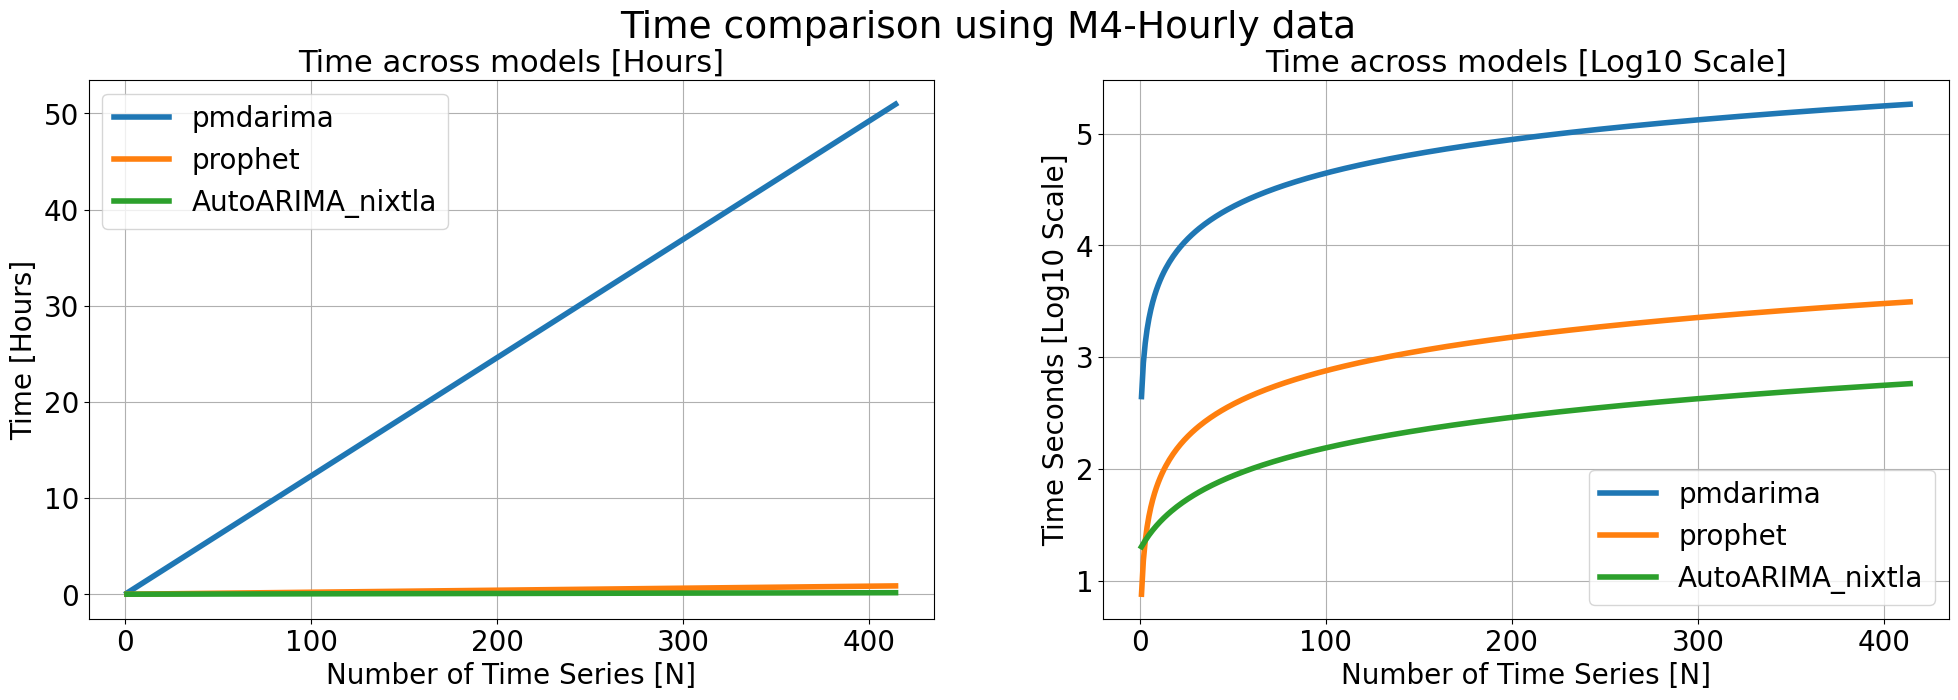

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (24, 7))
(times/3600).plot(ax=axes[0], linewidth=4)
np.log10(times).plot(ax=axes[1], linewidth=4)
axes[0].set_title('Time across models [Hours]', fontsize=22)
axes[1].set_title('Time across models [Log10 Scale]', fontsize=22)
axes[0].set_ylabel('Time [Hours]', fontsize=20)
axes[1].set_ylabel('Time Seconds [Log10 Scale]', fontsize=20)
fig.suptitle('Time comparison using M4-Hourly data', fontsize=27)
for ax in axes:
    ax.set_xlabel('Number of Time Series [N]', fontsize=20)
    ax.legend(prop={'size': 20})
    ax.grid()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)


In [ ]:
fig.savefig('computational-efficiency.png', dpi=300)

### Performance

#### pmdarima (only two time series)

In [ ]:
name_models = test.drop(columns=['unique_id', 'ds', 'y_test']).columns.tolist()

In [ ]:
test_pmdarima = test.query('unique_id in ["H1", "H10"]')
eval_pmdarima = []
for model in name_models:
    mae = np.mean(abs(test_pmdarima[model] - test_pmdarima['y_test']))
    eval_pmdarima.append({'model': model, 'mae': mae})
pd.DataFrame(eval_pmdarima).sort_values('mae')

,model,mae
0,AutoARIMA,20.289669
1,pmdarima,24.676279
2,prophet,39.201933


#### Prophet

In [ ]:
eval_prophet = []
for model in name_models:
    if 'pmdarima' in model:
        continue
    mae = np.mean(abs(test[model] - test['y_test']))
    eval_prophet.append({'model': model, 'mae': mae})
pd.DataFrame(eval_prophet).sort_values('mae')

,model,mae
0,AutoARIMA,680.202965
1,prophet,1058.578963


For a complete comparison check the [complete experiment](https://github.com/Nixtla/statsforecast/tree/v0.6.0/experiments/arima).

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/AutoArima_vs_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>